<a href="https://colab.research.google.com/github/Paul-Steve-Mithun/FSL_AUTONOMOUS_DRIVING/blob/main/FSL_MODEL_EVALUATE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch-summary torch-lr-finder timm easyfsl
!pip install torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 8.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torchsummary import summary
from tqdm import tqdm
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set random seed for reproducibility
torch.manual_seed(0)

# Set the path to your dataset
data_path = '/content/drive/MyDrive/datasets/Steve_Dataset'  # Adjust this path

# Check the classes in the dataset
class_name = os.listdir(data_path)
print(class_name)

['Car', 'Truck', 'Bike', 'Pedestrians']


Number of samples in Car category: 1500
Number of samples in Truck category: 167
Number of samples in Bike category: 820
Number of samples in Pedestrians category: 440


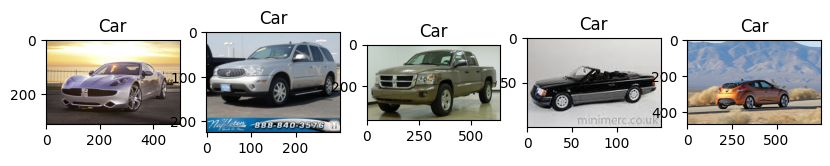

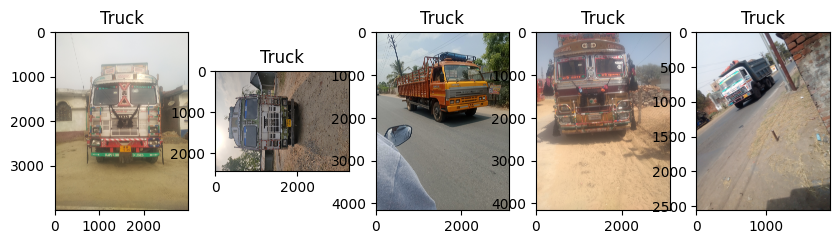

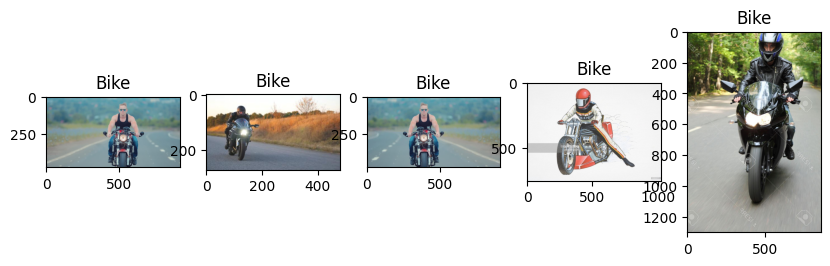

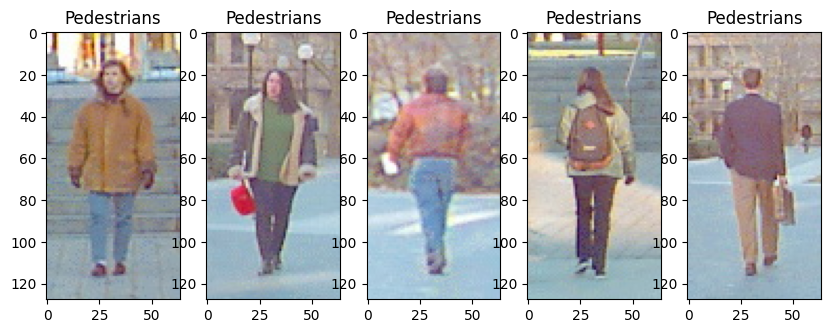

In [ ]:
def get_count(each_class):
    return len(os.listdir(data_path + '/' + each_class))

for each_class in class_name:
    print(f"Number of samples in {each_class} category: {get_count(each_class)}")

directory = os.listdir(data_path)
for each in directory:
    plt.figure(figsize=(10, 10))
    currentFolder = data_path + '/' + each
    for i, file in enumerate(os.listdir(currentFolder)[0:5]):
        fullpath = data_path + '/' + each + "/" + file
        img = mpimg.imread(fullpath)
        ax = plt.subplot(1, 5, i + 1)
        ax.set_title(each)
        plt.imshow(img)

In [ ]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(self, support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor) -> torch.Tensor:
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)
        n_way = len(torch.unique(support_labels))
        z_proto = torch.cat([z_support[torch.nonzero(support_labels == label)].mean(0) for label in range(n_way)])
        dists = torch.cdist(z_query, z_proto)
        scores = -dists
        return scores

# Use ResNet-50 as the backbone
convolutional_network = resnet50(pretrained=True)
convolutional_network.fc = nn.Flatten()  # Flatten the output of the backbone's last layer
model = PrototypicalNetworks(convolutional_network)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 110MB/s]


PrototypicalNetworks(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [ ]:
from PIL import Image
import os
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.images = []
        self.labels = []

        self.class_names = sorted(os.listdir(data_path))
        for label, class_name in enumerate(self.class_names):
            current_folder = os.path.join(data_path, class_name)
            for i, file in enumerate(os.listdir(current_folder)):
                fullpath = os.path.join(current_folder, file)

                # Check if the image can be opened and loaded successfully
                try:
                    # Attempt to open and load the image
                    with Image.open(fullpath) as im:
                        im.load()  # Force loading the image data

                    self.images.append(fullpath)
                    self.labels.append(label)
                except IOError:
                    print(f"Skipping corrupted image: {fullpath}")  # Log the skipped image

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        # Open image within a try-except block to catch potential errors
        try:
            image = Image.open(img_path)
        except IOError:
            print(f"Error opening image: {img_path}")
            return None, None  # Return None for both image and label if error

        # Check if image is palette with transparency
        if image.mode == 'P' and 'transparency' in image.info:
            image = image.convert('RGBA')

        image = image.convert('RGB')  # Ensure RGB format for consistency

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
N_WAY = 4  # Number of classes in a task
N_SHOT = 15  # Number of images per class in the support set
N_QUERY = 1  # Number of images per class in the query set
N_EVALUATION_TASKS = 50

test_set = CustomDataset(data_path, transform=transform)
test_set.get_labels = lambda: [instance[1] for instance in zip(test_set.images, test_set.labels)]

test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=4,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)


In [ ]:
# Set device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

PrototypicalNetworks(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [ ]:
def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor) -> [int, int]:
    support_images = support_images.to(device)
    support_labels = support_labels.to(device)
    query_images = query_images.to(device)
    query_labels = query_labels.to(device)

    with torch.no_grad():
        output = model(support_images, support_labels, query_images)
    predicted_labels = torch.max(output, 1)[1]
    correct_predictions = (predicted_labels == query_labels).sum().item()
    return correct_predictions, len(query_labels)

def evaluate(data_loader: DataLoader):
    total_predictions = 0
    correct_predictions = 0

    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, _) in tqdm(enumerate(data_loader), total=len(data_loader)):
            correct, total = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct

    accuracy = 100 * correct_predictions / total_predictions
    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {accuracy:.2f}%")
    return accuracy

# Evaluate over multiple episodes
accuracies = []
for _ in range(5):  # Adjust the number of evaluation episodes
    accuracy = evaluate(test_loader)
    accuracies.append(accuracy)

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
print(f"Mean Accuracy: {mean_accuracy:.2f}%, Std: {std_accuracy:.2f}%")


100%|██████████| 50/50 [16:49<00:00, 20.19s/it]

Model tested on 50 tasks. Accuracy: 96.50%



100%|██████████| 50/50 [16:42<00:00, 20.05s/it]

Model tested on 50 tasks. Accuracy: 92.50%



100%|██████████| 50/50 [16:40<00:00, 20.00s/it]

Model tested on 50 tasks. Accuracy: 88.50%



100%|██████████| 50/50 [16:42<00:00, 20.04s/it]

Model tested on 50 tasks. Accuracy: 92.50%



100%|██████████| 50/50 [16:34<00:00, 19.89s/it]

Model tested on 50 tasks. Accuracy: 94.00%
Mean Accuracy: 92.80%, Std: 2.60%


In [ ]:
import torch
import os

# Define the path to save the model
save_path = '/content/drive/MyDrive/prototypical_networks_evalmodel1.pth'

def save_checkpoint(model, epoch, mean_accuracy, std_accuracy, file_path):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'epoch': epoch,
        'mean_accuracy': mean_accuracy,
        'std_accuracy': std_accuracy
    }
    torch.save(checkpoint, file_path)
    print(f"Checkpoint saved at epoch {epoch} with mean accuracy: {mean_accuracy:.2f}%")

# Example usage after training for 10 epochs
save_checkpoint(model, epoch=10, mean_accuracy=mean_accuracy, std_accuracy=std_accuracy, file_path=save_path)


Checkpoint saved at epoch 10 with mean accuracy: 92.80%
